In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(f"Found TF-DF {tfdf.__version__}")

Found TF-DF 1.8.1


# 载入数据

In [4]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 数据预处理

In [5]:
#进行以下两个操作
#将名字分割成token
#提取船票的前缀
def preprocess(df):
    df=df.copy()
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    def ticket_number(x):
        return x.split(" ")[-1]
    def ticket_item(x):
        items=x.split(" ")
        if len(items)==1:
            return "NONE"
        return "_".join(items[0:-1])
    #去除Name元素中的各种符号换成" "
    df["Name"]=df["Name"].apply(normalize_name)
    #将Ticket的number和item分割成两列写入数据中
    df["Ticket_number"]=df["Ticket"].apply(ticket_number)
    df["Ticket_item"]=df["Ticket"].apply(ticket_item)
    return df
preprocessed_train_df=preprocess(train_df)
preprocessed_test_df=preprocess(test_df)
preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


In [6]:
#特征选择
input_features=list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
print(f"Input features:{input_features}")

Input features:['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


In [7]:
#将pandas数据转换为Tensorflow数据
def tokenize_names(features,labels=None):
    """将名字划分为单词"""
    features["Name"]=tf.strings.split(features["Name"])
    return features,labels
#map()用于对数据集中的每个元素应用指定的函数，并返回一个新的数据集
train_ds=tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_train_df,label="Survived").map(tokenize_names)
test_ds=tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_test_df).map(tokenize_names)

# 训练模型

In [8]:
#使用默认参数训练梯度提升树
model=tfdf.keras.GradientBoostedTreesModel(
    verbose=0,#不输出训练过程信息
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],#选择对应特征
    exclude_non_specified_features=True,#只使用在features参数中指定的特征，若为False将使用除在features参数中指定特征外的所有特征
    random_seed=1234,
)
model.fit(train_ds)
#创建inspector对象，调用该对象的evaluation()方法，返回在训练集上的评估结果
self_evaluation=model.make_inspector().evaluation()
print(f"Accuracy:{self_evaluation.accuracy} Loss:{self_evaluation.loss}")
model.summary()

[WARNING 24-02-26 06:10:18.0047 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 06:10:18.0056 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 06:10:18.0056 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 06:10:23.1247 UTC kernel.cc:1233] Loading model from path /tmp/tmpoxv55_cf/model/ with prefix c14923845c59412f
[INFO 24-02-26 06:10:23.1284 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-02-26 06:10:23.1287 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 06:10:23.1290 UTC kernel.cc:1061] Use fast generic engine


Accuracy:0.8260869383811951 Loss:0.8608942627906799


# 进行预测

In [17]:
#获取预测结果转化为DataFrame类型数据
def prediction_to_kaggle_format(model,threshold=0.5):
    proba_survive=model.predict(test_ds,verbose=0)[:,0]#预测结果为二维数组，每行对应每个样本的预测结果，每列对应一个类别的预测概率，因此取第一列及生存的概率
    return pd.DataFrame({
        "PassengerId":test_df["PassengerId"],
        "Survived":(proba_survive>=threshold).astype(int)
    })
#将DataFrame转化为csv
def make_submission(kaggle_predictions):
    path="/kaggle/working/submission.csv"
    kaggle_predictions.to_csv(path,index=False)
    print(f"Submission exported to {path}")
#kaggle_predictions=prediction_to_kaggle_format(model)
#make_submission(kaggle_predictions)
#显示存储的结果文件的前几行
#!head /kaggle/working/submission.csv

Submission exported to /kaggle/working/submission.csv
PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


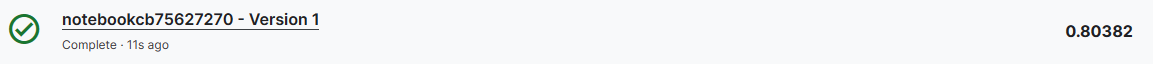
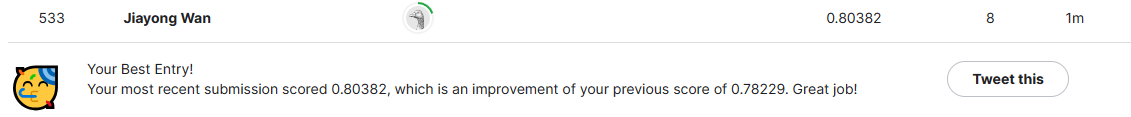

# 微调模型超参数

In [16]:
#创建随机搜索参数的tuner对象，指定尝试次数为1000次
tuner=tfdf.tuner.RandomSearch(num_trials=1000)
#设置决策树节点的最多可容纳样本数，节点样本数量达到该值时需要进行拆分
tuner.choice("min_examples",[2,5,7,10])
tuner.choice("categorical_algorithm",["CART","RANDOM"])#处理分类特征时可选的使用算法
#定义一个局部搜索空间对象，指定局部生长策略
local_search_space=tuner.choice("growing_strategy",["LOCAL"])
#指定决策树局部节点的最大深度
local_search_space.choice("max_depth",[3,4,5,6,8])
#定义全局搜索空间对象，将其与之前定义的局部搜索空间对象合并，指定全局的最佳生长优先策略，全局策略优先级高于局部策略
global_search_space=tuner.choice("growing_strategy",["BEST_FIRST_GLOBAL"],merge=True)
#指定树的全局最大节点数
global_search_space.choice("max_num_nodes",[16,32,64,128,256])
#设置缩减率，控制每棵树对最终预测结果的贡献
tuner.choice("shrinkage",[0.02,0.05,0.10,0.15])
#设置拆分节点时考虑的特征比例
tuner.choice("num_candidate_attributes_ratio",[0.2,0.5,0.9,1.0])
#设置节点分裂策略，轴对称分裂
tuner.choice("split_axis",["AXIS_ALIGNED"])
#斜面分裂策略，设置相关参数
oblique_space=tuner.choice("split_axis",["SPARSE_OBLIQUE"],merge=True)
oblique_space.choice("sparse_oblique_normalization",["NONE","STANDARD_DEVIATION","MIN_MAX"])
oblique_space.choice("sparse_oblique_weights",["BINARY","CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent",[1.0,1.5])

tuned_model=tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds,verbose=0)
tuned_self_evaluation=tuned_model.make_inspector().evaluation()
print(f"Accuracy:{tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")
kaggle_predictions=prediction_to_kaggle_format(tuned_model)
make_submission(kaggle_predictions)

Use /tmp/tmpeozquojv as temporary training directory


[WARNING 24-02-26 06:15:59.9150 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 06:15:59.9151 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 06:15:59.9151 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 06:17:28.0933 UTC kernel.cc:1233] Loading model from path /tmp/tmpeozquojv/model/ with prefix adae92b5dca74058
[INFO 24-02-26 06:17:28.1045 UTC decision_forest.cc:660] Model loaded with 30 root(s), 2236 node(s), and 12 input feature(s).
[INFO 24-02-26 06:17:28.1046 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-02-26 06:17:28.1046 UTC kernel.cc:1061] Use fast generic engine


Accuracy:0.8630136847496033 Loss:0.6749962568283081


结果估计是过拟合  
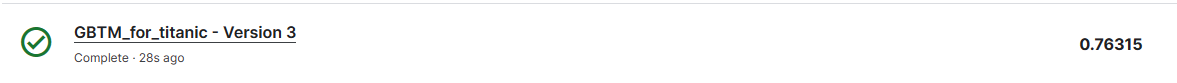

# 进行集成 

In [23]:
predictions=None
num_predictions=0
for i in range(100):
    print(f"i:{i}")
    model=tfdf.keras.GradientBoostedTreesModel(
        verbose=0,
        features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
        exclude_non_specified_features=True,
        random_seed=i,
        honest=True,#使用一部分样本确定树的结构，另一部分样本确定叶子节点的值
    )
    model.fit(train_ds)
    sub_predictions=model.predict(test_ds,verbose=0)[:,0]
    if predictions is None:
        predictions=sub_predictions
    else:
        predictions+=sub_predictions
    num_predictions+=1
predictions/=num_predictions
kaggle_predictions=pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":(predictions>=0.5).astype(int)   
})
make_submission(kaggle_predictions)

i:0


[WARNING 24-02-26 07:41:41.6698 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:41.6698 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:41.6698 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:42.1405 UTC kernel.cc:1233] Loading model from path /tmp/tmpd4u3j_ny/model/ with prefix f43cc63e293c43af
[INFO 24-02-26 07:41:42.1429 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-02-26 07:41:42.1432 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:41:42.1432 UTC kernel.cc:1061] Use fast generic engine


i:1


[WARNING 24-02-26 07:41:42.4818 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:42.4818 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:42.4818 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:43.3583 UTC kernel.cc:1233] Loading model from path /tmp/tmpw0zi6nir/model/ with prefix 857ce4497e18430a
[INFO 24-02-26 07:41:43.3683 UTC kernel.cc:1061] Use fast generic engine


i:2


[WARNING 24-02-26 07:41:43.7091 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:43.7091 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:43.7091 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:44.2154 UTC kernel.cc:1233] Loading model from path /tmp/tmpinjr1cn9/model/ with prefix c6e6ec294eb040a5
[INFO 24-02-26 07:41:44.2179 UTC kernel.cc:1061] Use fast generic engine


i:3


[WARNING 24-02-26 07:41:44.5492 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:44.5492 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:44.5492 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:45.6002 UTC kernel.cc:1233] Loading model from path /tmp/tmpx9b3jesx/model/ with prefix 24dda60143654155
[INFO 24-02-26 07:41:45.6140 UTC kernel.cc:1061] Use fast generic engine


i:4


[WARNING 24-02-26 07:41:45.9496 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:45.9496 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:45.9497 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:46.4923 UTC kernel.cc:1233] Loading model from path /tmp/tmpx_1dr4wj/model/ with prefix bb19182d142b46e0
[INFO 24-02-26 07:41:46.4956 UTC kernel.cc:1061] Use fast generic engine


i:5


[WARNING 24-02-26 07:41:46.9673 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:46.9674 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:46.9674 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:47.4774 UTC kernel.cc:1233] Loading model from path /tmp/tmpme6zca7w/model/ with prefix 5c0b05203fa94299
[INFO 24-02-26 07:41:47.4792 UTC kernel.cc:1061] Use fast generic engine


i:6


[WARNING 24-02-26 07:41:47.8203 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:47.8203 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:47.8203 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:48.4181 UTC kernel.cc:1233] Loading model from path /tmp/tmp5x80fqax/model/ with prefix 23cfa7765bd241aa
[INFO 24-02-26 07:41:48.4225 UTC kernel.cc:1061] Use fast generic engine


i:7


[WARNING 24-02-26 07:41:48.7680 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:48.7680 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:48.7680 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:49.6706 UTC kernel.cc:1233] Loading model from path /tmp/tmpn12kbfl6/model/ with prefix 36b2679af4fe4b8f
[INFO 24-02-26 07:41:49.6823 UTC kernel.cc:1061] Use fast generic engine


i:8


[WARNING 24-02-26 07:41:50.0227 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:50.0227 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:50.0227 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:50.6611 UTC kernel.cc:1233] Loading model from path /tmp/tmp85q6u4t6/model/ with prefix e248355c2f1b4e79
[INFO 24-02-26 07:41:50.6664 UTC kernel.cc:1061] Use fast generic engine


i:9


[WARNING 24-02-26 07:41:50.9946 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:50.9947 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:50.9947 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:51.7403 UTC kernel.cc:1233] Loading model from path /tmp/tmpmagk93_w/model/ with prefix 833504a122b249ba
[INFO 24-02-26 07:41:51.7481 UTC kernel.cc:1061] Use fast generic engine


i:10


[WARNING 24-02-26 07:41:52.6367 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:52.6367 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:52.6367 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:53.1608 UTC kernel.cc:1233] Loading model from path /tmp/tmpeavvp08k/model/ with prefix 891475eb6b5f476b
[INFO 24-02-26 07:41:53.1639 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:41:53.1640 UTC kernel.cc:1061] Use fast generic engine


i:11


[WARNING 24-02-26 07:41:53.4937 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:53.4938 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:53.4938 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:54.2651 UTC kernel.cc:1233] Loading model from path /tmp/tmpsfqu56xg/model/ with prefix e2f3a85bca534159
[INFO 24-02-26 07:41:54.2732 UTC kernel.cc:1061] Use fast generic engine


i:12


[WARNING 24-02-26 07:41:54.6066 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:54.6067 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:54.6067 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:55.1470 UTC kernel.cc:1233] Loading model from path /tmp/tmp_68tligc/model/ with prefix 5cfc1a54739e4290
[INFO 24-02-26 07:41:55.1503 UTC kernel.cc:1061] Use fast generic engine


i:13


[WARNING 24-02-26 07:41:55.4621 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:55.4621 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:55.4621 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:56.1343 UTC kernel.cc:1233] Loading model from path /tmp/tmpyic4yxmn/model/ with prefix 77305a8db3504fc4
[INFO 24-02-26 07:41:56.1403 UTC kernel.cc:1061] Use fast generic engine


i:14


[WARNING 24-02-26 07:41:56.4795 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:56.4796 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:56.4796 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:57.0062 UTC kernel.cc:1233] Loading model from path /tmp/tmps7f72g6k/model/ with prefix 15332d44edc04e7d
[INFO 24-02-26 07:41:57.0094 UTC kernel.cc:1061] Use fast generic engine


i:15


[WARNING 24-02-26 07:41:57.3509 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:57.3509 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:57.3509 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:57.9547 UTC kernel.cc:1233] Loading model from path /tmp/tmprimqf0ki/model/ with prefix eb0de3602c524f37
[INFO 24-02-26 07:41:57.9587 UTC kernel.cc:1061] Use fast generic engine


i:16


[WARNING 24-02-26 07:41:58.3956 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:58.3956 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:58.3956 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:41:59.0883 UTC kernel.cc:1233] Loading model from path /tmp/tmp4fgq82g2/model/ with prefix 442cb0874d7b40ad
[INFO 24-02-26 07:41:59.0951 UTC kernel.cc:1061] Use fast generic engine


i:17


[WARNING 24-02-26 07:41:59.4265 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:59.4265 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:41:59.4265 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:00.1548 UTC kernel.cc:1233] Loading model from path /tmp/tmp_ck1i7w5/model/ with prefix 2303e64595844008
[INFO 24-02-26 07:42:00.1616 UTC kernel.cc:1061] Use fast generic engine


i:18


[WARNING 24-02-26 07:42:00.4685 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:00.4685 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:00.4685 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:01.1324 UTC kernel.cc:1233] Loading model from path /tmp/tmppoqxyiud/model/ with prefix e3998e928bd34628
[INFO 24-02-26 07:42:01.1387 UTC kernel.cc:1061] Use fast generic engine


i:19


[WARNING 24-02-26 07:42:01.4692 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:01.4693 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:01.4693 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:02.3037 UTC kernel.cc:1233] Loading model from path /tmp/tmp8c5_f5de/model/ with prefix 144948fae5054236
[INFO 24-02-26 07:42:02.3146 UTC kernel.cc:1061] Use fast generic engine


i:20


[WARNING 24-02-26 07:42:02.6417 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:02.6417 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:02.6417 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:03.4464 UTC kernel.cc:1233] Loading model from path /tmp/tmpiwrs2g_j/model/ with prefix 24ac10730de1417d
[INFO 24-02-26 07:42:03.4553 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:42:03.4553 UTC kernel.cc:1061] Use fast generic engine


i:21


[WARNING 24-02-26 07:42:03.7981 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:03.7981 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:03.7981 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:04.3261 UTC kernel.cc:1233] Loading model from path /tmp/tmp8qqt8bp3/model/ with prefix 42f0b79b935645f2
[INFO 24-02-26 07:42:04.3292 UTC kernel.cc:1061] Use fast generic engine


i:22


[WARNING 24-02-26 07:42:04.6567 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:04.6567 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:04.6567 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:05.2112 UTC kernel.cc:1233] Loading model from path /tmp/tmph4qab31w/model/ with prefix 408699b2f539488a
[INFO 24-02-26 07:42:05.2143 UTC kernel.cc:1061] Use fast generic engine


i:23


[WARNING 24-02-26 07:42:05.5459 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:05.5459 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:05.5459 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:06.1540 UTC kernel.cc:1233] Loading model from path /tmp/tmpk_pw7lg6/model/ with prefix 97d4f44631cb46ce
[INFO 24-02-26 07:42:06.1587 UTC kernel.cc:1061] Use fast generic engine


i:24


[WARNING 24-02-26 07:42:06.4996 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:06.4996 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:06.4996 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:07.0258 UTC kernel.cc:1233] Loading model from path /tmp/tmp3b80bf4x/model/ with prefix df06daea5f3e4502
[INFO 24-02-26 07:42:07.0290 UTC kernel.cc:1061] Use fast generic engine


i:25


[WARNING 24-02-26 07:42:07.3518 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:07.3518 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:07.3518 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:08.0474 UTC kernel.cc:1233] Loading model from path /tmp/tmpr_0tfgy6/model/ with prefix 7fe41aba83074eb7
[INFO 24-02-26 07:42:08.0539 UTC kernel.cc:1061] Use fast generic engine


i:26


[WARNING 24-02-26 07:42:08.3907 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:08.3907 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:08.3908 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:09.0384 UTC kernel.cc:1233] Loading model from path /tmp/tmp2hpvormy/model/ with prefix 94a92584aef240ca
[INFO 24-02-26 07:42:09.0436 UTC kernel.cc:1061] Use fast generic engine


i:27


[WARNING 24-02-26 07:42:10.0378 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:10.0378 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:10.0378 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:10.5940 UTC kernel.cc:1233] Loading model from path /tmp/tmp4o8uld9k/model/ with prefix d11f98b13d3f4157
[INFO 24-02-26 07:42:10.5974 UTC kernel.cc:1061] Use fast generic engine


i:28


[WARNING 24-02-26 07:42:10.9727 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:10.9728 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:10.9728 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:11.5051 UTC kernel.cc:1233] Loading model from path /tmp/tmpoanxgz38/model/ with prefix 0589926807654f02
[INFO 24-02-26 07:42:11.5077 UTC kernel.cc:1061] Use fast generic engine


i:29


[WARNING 24-02-26 07:42:12.0067 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:12.0068 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:12.0068 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:12.7428 UTC kernel.cc:1233] Loading model from path /tmp/tmpoi9i804d/model/ with prefix 2b7f9c82229449f5
[INFO 24-02-26 07:42:12.7491 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-02-26 07:42:12.7497 UTC kernel.cc:1061] Use fast generic engine


i:30


[WARNING 24-02-26 07:42:13.6665 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:13.6665 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:13.6666 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:14.7393 UTC kernel.cc:1233] Loading model from path /tmp/tmpzkrgteij/model/ with prefix 38c59320311c4f5e
[INFO 24-02-26 07:42:14.7546 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:42:14.7547 UTC kernel.cc:1061] Use fast generic engine


i:31


[WARNING 24-02-26 07:42:15.1127 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:15.1128 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:15.1128 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:15.7445 UTC kernel.cc:1233] Loading model from path /tmp/tmpd2bw3zz_/model/ with prefix 03e78feaa111482f
[INFO 24-02-26 07:42:15.7495 UTC kernel.cc:1061] Use fast generic engine


i:32


[WARNING 24-02-26 07:42:16.0988 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:16.0988 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:16.0988 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:16.6525 UTC kernel.cc:1233] Loading model from path /tmp/tmpa_t47op8/model/ with prefix 5357522c2b7047f6
[INFO 24-02-26 07:42:16.6554 UTC kernel.cc:1061] Use fast generic engine


i:33


[WARNING 24-02-26 07:42:16.9992 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:16.9992 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:16.9992 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:17.7555 UTC kernel.cc:1233] Loading model from path /tmp/tmpg3l9ouwt/model/ with prefix c56dd43e30bf4df7
[INFO 24-02-26 07:42:17.7625 UTC kernel.cc:1061] Use fast generic engine


i:34


[WARNING 24-02-26 07:42:18.1176 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:18.1176 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:18.1176 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:18.7320 UTC kernel.cc:1233] Loading model from path /tmp/tmp_yhjs7ms/model/ with prefix cb3819f0950b404f
[INFO 24-02-26 07:42:18.7365 UTC kernel.cc:1061] Use fast generic engine


i:35


[WARNING 24-02-26 07:42:19.0824 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:19.0825 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:19.0825 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:21.0280 UTC kernel.cc:1233] Loading model from path /tmp/tmpezvzoy_s/model/ with prefix b0a60751e0bd4cdf
[INFO 24-02-26 07:42:21.0367 UTC kernel.cc:1061] Use fast generic engine


i:36


[WARNING 24-02-26 07:42:21.5547 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:21.5547 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:21.5547 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:22.3853 UTC kernel.cc:1233] Loading model from path /tmp/tmp00ir77ma/model/ with prefix c8e6d638c23741e0
[INFO 24-02-26 07:42:22.3957 UTC kernel.cc:1061] Use fast generic engine


i:37


[WARNING 24-02-26 07:42:22.7833 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:22.7833 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:22.7833 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:23.4419 UTC kernel.cc:1233] Loading model from path /tmp/tmphxbpxwkl/model/ with prefix d5c4df3c61e44903
[INFO 24-02-26 07:42:23.4481 UTC kernel.cc:1061] Use fast generic engine


i:38


[WARNING 24-02-26 07:42:23.8190 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:23.8190 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:23.8191 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:24.6132 UTC kernel.cc:1233] Loading model from path /tmp/tmppslb3kzq/model/ with prefix c5a8519a0248453a
[INFO 24-02-26 07:42:24.6220 UTC kernel.cc:1061] Use fast generic engine


i:39


[WARNING 24-02-26 07:42:24.9920 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:24.9921 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:24.9921 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:25.7534 UTC kernel.cc:1233] Loading model from path /tmp/tmpfnhjj42n/model/ with prefix 595c07064bce4b53
[INFO 24-02-26 07:42:25.7616 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:42:25.7616 UTC kernel.cc:1061] Use fast generic engine


i:40


[WARNING 24-02-26 07:42:26.1240 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:26.1240 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:26.1240 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:26.6493 UTC kernel.cc:1233] Loading model from path /tmp/tmpzzqnusdu/model/ with prefix a5f0638be74f49f2
[INFO 24-02-26 07:42:26.6526 UTC kernel.cc:1061] Use fast generic engine


i:41


[WARNING 24-02-26 07:42:27.0084 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:27.0084 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:27.0084 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:27.8141 UTC kernel.cc:1233] Loading model from path /tmp/tmpx498zusn/model/ with prefix 770dcd111ca44de6
[INFO 24-02-26 07:42:27.8233 UTC kernel.cc:1061] Use fast generic engine


i:42


[WARNING 24-02-26 07:42:28.6896 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:28.6896 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:28.6896 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:29.3360 UTC kernel.cc:1233] Loading model from path /tmp/tmpe10xti_w/model/ with prefix c2bf71a1705149e3
[INFO 24-02-26 07:42:29.3417 UTC kernel.cc:1061] Use fast generic engine


i:43


[WARNING 24-02-26 07:42:29.7167 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:29.7168 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:29.7168 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:30.5530 UTC kernel.cc:1233] Loading model from path /tmp/tmp03la5pys/model/ with prefix 52c444e10b6d40bc
[INFO 24-02-26 07:42:30.5632 UTC kernel.cc:1061] Use fast generic engine


i:44


[WARNING 24-02-26 07:42:30.9190 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:30.9191 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:30.9191 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:31.5776 UTC kernel.cc:1233] Loading model from path /tmp/tmp066dj0o5/model/ with prefix 888b6a2f80fa471b
[INFO 24-02-26 07:42:31.5834 UTC kernel.cc:1061] Use fast generic engine


i:45


[WARNING 24-02-26 07:42:31.9345 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:31.9346 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:31.9346 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:32.4624 UTC kernel.cc:1233] Loading model from path /tmp/tmpq71onkng/model/ with prefix 70f27ff8ea5d4ba8
[INFO 24-02-26 07:42:32.4651 UTC kernel.cc:1061] Use fast generic engine


i:46


[WARNING 24-02-26 07:42:32.9796 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:32.9796 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:32.9796 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:33.7962 UTC kernel.cc:1233] Loading model from path /tmp/tmpvpcbqah5/model/ with prefix c659748820904830
[INFO 24-02-26 07:42:33.8042 UTC kernel.cc:1061] Use fast generic engine


i:47


[WARNING 24-02-26 07:42:34.1420 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:34.1421 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:34.1421 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:34.8456 UTC kernel.cc:1233] Loading model from path /tmp/tmp80uw73th/model/ with prefix 50f292e0de0c41da
[INFO 24-02-26 07:42:34.8525 UTC kernel.cc:1061] Use fast generic engine


i:48


[WARNING 24-02-26 07:42:35.7863 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:35.7863 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:35.7863 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:36.2998 UTC kernel.cc:1233] Loading model from path /tmp/tmp1axgroet/model/ with prefix 1428ea45dc2d4b30
[INFO 24-02-26 07:42:36.3024 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:42:36.3024 UTC kernel.cc:1061] Use fast generic engine


i:49


[WARNING 24-02-26 07:42:36.6249 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:36.6249 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:36.6249 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:37.1919 UTC kernel.cc:1233] Loading model from path /tmp/tmpyueh14hn/model/ with prefix 8a25cc32db3149a1
[INFO 24-02-26 07:42:37.1955 UTC kernel.cc:1061] Use fast generic engine


i:50


[WARNING 24-02-26 07:42:37.6402 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:37.6402 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:37.6402 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:38.3223 UTC kernel.cc:1233] Loading model from path /tmp/tmpwccdw69a/model/ with prefix 23476501e3114c07
[INFO 24-02-26 07:42:38.3290 UTC kernel.cc:1061] Use fast generic engine


i:51


[WARNING 24-02-26 07:42:38.6663 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:38.6664 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:38.6664 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:39.4726 UTC kernel.cc:1233] Loading model from path /tmp/tmpp654r27o/model/ with prefix 389a8d90e3554c6d
[INFO 24-02-26 07:42:39.4806 UTC kernel.cc:1061] Use fast generic engine


i:52


[WARNING 24-02-26 07:42:39.8165 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:39.8165 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:39.8165 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:40.4006 UTC kernel.cc:1233] Loading model from path /tmp/tmpua2i08no/model/ with prefix 35c40ea25a414e5f
[INFO 24-02-26 07:42:40.4046 UTC kernel.cc:1061] Use fast generic engine


i:53


[WARNING 24-02-26 07:42:40.7392 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:40.7392 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:40.7392 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:41.3158 UTC kernel.cc:1233] Loading model from path /tmp/tmp4y0p4kx0/model/ with prefix 7f56ba5f0dc14279
[INFO 24-02-26 07:42:41.3197 UTC kernel.cc:1061] Use fast generic engine


i:54


[WARNING 24-02-26 07:42:41.6402 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:41.6402 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:41.6402 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:42.1100 UTC kernel.cc:1233] Loading model from path /tmp/tmpood_2adt/model/ with prefix 6fec23f8a9854417
[INFO 24-02-26 07:42:42.1118 UTC kernel.cc:1061] Use fast generic engine


i:55


[WARNING 24-02-26 07:42:42.4456 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:42.4456 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:42.4456 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:43.1892 UTC kernel.cc:1233] Loading model from path /tmp/tmp1xnqbzdr/model/ with prefix 7b17a2862db447c8
[INFO 24-02-26 07:42:43.1962 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-02-26 07:42:43.1970 UTC kernel.cc:1061] Use fast generic engine


i:56


[WARNING 24-02-26 07:42:43.5256 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:43.5256 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:43.5256 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:44.1499 UTC kernel.cc:1233] Loading model from path /tmp/tmpo12kovx2/model/ with prefix 0b8a639acb91464f
[INFO 24-02-26 07:42:44.1556 UTC kernel.cc:1061] Use fast generic engine


i:57


[WARNING 24-02-26 07:42:44.4979 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:44.4979 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:44.4979 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:44.9658 UTC kernel.cc:1233] Loading model from path /tmp/tmp10flc2pg/model/ with prefix 3208369050ec41ec
[INFO 24-02-26 07:42:44.9679 UTC kernel.cc:1061] Use fast generic engine


i:58


[WARNING 24-02-26 07:42:45.2884 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:45.2884 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:45.2884 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:45.8432 UTC kernel.cc:1233] Loading model from path /tmp/tmpfboje3xl/model/ with prefix a22458fd358a4052
[INFO 24-02-26 07:42:45.8465 UTC kernel.cc:1061] Use fast generic engine


i:59


[WARNING 24-02-26 07:42:46.1940 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:46.1940 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:46.1940 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:46.8344 UTC kernel.cc:1233] Loading model from path /tmp/tmpz9xis8mr/model/ with prefix af1934265ee44f26
[INFO 24-02-26 07:42:46.8391 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:42:46.8392 UTC kernel.cc:1061] Use fast generic engine


i:60


[WARNING 24-02-26 07:42:47.1832 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:47.1832 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:47.1832 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:47.9157 UTC kernel.cc:1233] Loading model from path /tmp/tmpf08aq28y/model/ with prefix 08a1116f3c8b44b9
[INFO 24-02-26 07:42:47.9213 UTC kernel.cc:1061] Use fast generic engine


i:61


[WARNING 24-02-26 07:42:48.2734 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:48.2735 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:48.2735 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:48.8438 UTC kernel.cc:1233] Loading model from path /tmp/tmp7r0svp09/model/ with prefix 464f562f17154079
[INFO 24-02-26 07:42:48.8463 UTC kernel.cc:1061] Use fast generic engine


i:62


[WARNING 24-02-26 07:42:49.1906 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:49.1907 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:49.1907 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:49.9522 UTC kernel.cc:1233] Loading model from path /tmp/tmpszxqamfy/model/ with prefix f5e1c53ffbeb463a
[INFO 24-02-26 07:42:49.9586 UTC kernel.cc:1061] Use fast generic engine


i:63


[WARNING 24-02-26 07:42:50.2871 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:50.2872 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:50.2872 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:50.8961 UTC kernel.cc:1233] Loading model from path /tmp/tmpr1wafcxj/model/ with prefix 0894685a291747dd
[INFO 24-02-26 07:42:50.9008 UTC kernel.cc:1061] Use fast generic engine


i:64


[WARNING 24-02-26 07:42:51.2514 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:51.2514 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:51.2514 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:51.8525 UTC kernel.cc:1233] Loading model from path /tmp/tmpu9g4zet8/model/ with prefix d52f449b544a40de
[INFO 24-02-26 07:42:51.8566 UTC kernel.cc:1061] Use fast generic engine


i:65


[WARNING 24-02-26 07:42:52.2080 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:52.2081 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:52.2081 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:52.7298 UTC kernel.cc:1233] Loading model from path /tmp/tmpfubesbc8/model/ with prefix 22b4274fc93a41c1
[INFO 24-02-26 07:42:52.7326 UTC kernel.cc:1061] Use fast generic engine


i:66


[WARNING 24-02-26 07:42:53.2318 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:53.2319 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:53.2319 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:53.8002 UTC kernel.cc:1233] Loading model from path /tmp/tmpoef2h4_p/model/ with prefix 65613ec825644de3
[INFO 24-02-26 07:42:53.8037 UTC kernel.cc:1061] Use fast generic engine


i:67


[WARNING 24-02-26 07:42:54.1433 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:54.1433 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:54.1434 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:55.0129 UTC kernel.cc:1233] Loading model from path /tmp/tmpxt5848j3/model/ with prefix 8e52f935b0d54531
[INFO 24-02-26 07:42:55.0234 UTC kernel.cc:1061] Use fast generic engine


i:68


[WARNING 24-02-26 07:42:55.3725 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:55.3725 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:55.3725 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:56.0428 UTC kernel.cc:1233] Loading model from path /tmp/tmpctr9a0nm/model/ with prefix f201ffb210354cb7
[INFO 24-02-26 07:42:56.0491 UTC kernel.cc:1061] Use fast generic engine


i:69


[WARNING 24-02-26 07:42:57.0288 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:57.0288 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:57.0288 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:57.6504 UTC kernel.cc:1233] Loading model from path /tmp/tmpm8updpwc/model/ with prefix 22b004ef2ae14284
[INFO 24-02-26 07:42:57.6538 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:42:57.6539 UTC kernel.cc:1061] Use fast generic engine


i:70


[WARNING 24-02-26 07:42:58.0088 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:58.0089 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:58.0089 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:58.6434 UTC kernel.cc:1233] Loading model from path /tmp/tmpmh3je0fd/model/ with prefix f1dbcf1643294470
[INFO 24-02-26 07:42:58.6479 UTC kernel.cc:1061] Use fast generic engine


i:71


[WARNING 24-02-26 07:42:58.9713 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:58.9714 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:58.9714 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:42:59.6349 UTC kernel.cc:1233] Loading model from path /tmp/tmp5wi2c9ls/model/ with prefix e0cf11fc365a431c
[INFO 24-02-26 07:42:59.6399 UTC kernel.cc:1061] Use fast generic engine


i:72


[WARNING 24-02-26 07:42:59.9842 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:59.9842 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:42:59.9843 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:00.7711 UTC kernel.cc:1233] Loading model from path /tmp/tmp1ahd40k_/model/ with prefix a8bfffdec8a04ad8
[INFO 24-02-26 07:43:00.7803 UTC kernel.cc:1061] Use fast generic engine


i:73


[WARNING 24-02-26 07:43:01.6465 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:01.6465 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:01.6465 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:02.2732 UTC kernel.cc:1233] Loading model from path /tmp/tmp_n9l8n1_/model/ with prefix 5b5c6788451e47d8
[INFO 24-02-26 07:43:02.2772 UTC kernel.cc:1061] Use fast generic engine


i:74


[WARNING 24-02-26 07:43:02.7083 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:02.7083 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:02.7083 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:03.4711 UTC kernel.cc:1233] Loading model from path /tmp/tmpag_vccbu/model/ with prefix 7205454562ca4b0a
[INFO 24-02-26 07:43:03.4782 UTC kernel.cc:1061] Use fast generic engine


i:75


[WARNING 24-02-26 07:43:04.4036 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:04.4036 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:04.4036 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:05.0298 UTC kernel.cc:1233] Loading model from path /tmp/tmpq48db075/model/ with prefix bbb2f78b18474505
[INFO 24-02-26 07:43:05.0343 UTC kernel.cc:1061] Use fast generic engine


i:76


[WARNING 24-02-26 07:43:05.3977 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:05.3977 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:05.3977 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:05.9136 UTC kernel.cc:1233] Loading model from path /tmp/tmp3uoq085h/model/ with prefix b9e2d51a111d4fa6
[INFO 24-02-26 07:43:05.9159 UTC kernel.cc:1061] Use fast generic engine


i:77


[WARNING 24-02-26 07:43:06.4274 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:06.4274 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:06.4274 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:06.9534 UTC kernel.cc:1233] Loading model from path /tmp/tmph84iuauu/model/ with prefix 736969efa99c4273
[INFO 24-02-26 07:43:06.9558 UTC kernel.cc:1061] Use fast generic engine


i:78


[WARNING 24-02-26 07:43:07.4580 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:07.4581 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:07.4581 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:08.0349 UTC kernel.cc:1233] Loading model from path /tmp/tmpdzrukigx/model/ with prefix b2b38ef137db4b45
[INFO 24-02-26 07:43:08.0385 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:43:08.0385 UTC kernel.cc:1061] Use fast generic engine


i:79


[WARNING 24-02-26 07:43:08.4820 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:08.4820 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:08.4820 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:09.0506 UTC kernel.cc:1233] Loading model from path /tmp/tmpr__70pl3/model/ with prefix aba0a8d62c4a450b
[INFO 24-02-26 07:43:09.0545 UTC kernel.cc:1061] Use fast generic engine


i:80


[WARNING 24-02-26 07:43:09.4042 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:09.4043 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:09.4043 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:10.1020 UTC kernel.cc:1233] Loading model from path /tmp/tmp6lw8lpzi/model/ with prefix 2b0a2f362c4d4aa5
[INFO 24-02-26 07:43:10.1070 UTC kernel.cc:1061] Use fast generic engine


i:81


[WARNING 24-02-26 07:43:10.4325 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:10.4326 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:10.4326 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:11.1284 UTC kernel.cc:1233] Loading model from path /tmp/tmpl_ak64ua/model/ with prefix 5feb6b2509f2471f
[INFO 24-02-26 07:43:11.1342 UTC kernel.cc:1061] Use fast generic engine


i:82


[WARNING 24-02-26 07:43:11.4682 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:11.4682 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:11.4683 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:12.1473 UTC kernel.cc:1233] Loading model from path /tmp/tmp404cmq2w/model/ with prefix a49f4032aa8d4279
[INFO 24-02-26 07:43:12.1524 UTC kernel.cc:1061] Use fast generic engine


i:83


[WARNING 24-02-26 07:43:12.5070 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:12.5070 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:12.5070 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:13.1525 UTC kernel.cc:1233] Loading model from path /tmp/tmpqnuqhtv8/model/ with prefix 2c09f3e9137144d5
[INFO 24-02-26 07:43:13.1573 UTC kernel.cc:1061] Use fast generic engine


i:84


[WARNING 24-02-26 07:43:13.5544 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:13.5545 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:13.5546 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:14.3671 UTC kernel.cc:1233] Loading model from path /tmp/tmpa_omnidh/model/ with prefix 424a7828fc904aee
[INFO 24-02-26 07:43:14.3747 UTC quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-02-26 07:43:14.3756 UTC kernel.cc:1061] Use fast generic engine


i:85


[WARNING 24-02-26 07:43:16.2259 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:16.2259 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:16.2259 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:16.9359 UTC kernel.cc:1233] Loading model from path /tmp/tmp58ica5b0/model/ with prefix 7e6cdff330b64fae
[INFO 24-02-26 07:43:16.9416 UTC kernel.cc:1061] Use fast generic engine


i:86


[WARNING 24-02-26 07:43:17.4280 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:17.4280 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:17.4280 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:18.3052 UTC kernel.cc:1233] Loading model from path /tmp/tmp2zxxtgf9/model/ with prefix d826bc1437fc4981
[INFO 24-02-26 07:43:18.3169 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:43:18.3169 UTC kernel.cc:1061] Use fast generic engine


i:87


[WARNING 24-02-26 07:43:18.7265 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:18.7265 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:18.7265 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:19.6883 UTC kernel.cc:1233] Loading model from path /tmp/tmpyoin_vdb/model/ with prefix c30c192fb5334ed1
[INFO 24-02-26 07:43:19.7007 UTC kernel.cc:1061] Use fast generic engine


i:88


[WARNING 24-02-26 07:43:20.0910 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:20.0911 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:20.0912 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:20.8183 UTC kernel.cc:1233] Loading model from path /tmp/tmpqybmikuo/model/ with prefix 1d338ef414ed4a13
[INFO 24-02-26 07:43:20.8263 UTC kernel.cc:1061] Use fast generic engine


i:89


[WARNING 24-02-26 07:43:21.2050 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:21.2050 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:21.2051 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:21.7828 UTC kernel.cc:1233] Loading model from path /tmp/tmpiwgotvld/model/ with prefix b97ef537694e4101
[INFO 24-02-26 07:43:21.7861 UTC kernel.cc:1061] Use fast generic engine


i:90


[WARNING 24-02-26 07:43:22.1608 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:22.1608 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:22.1608 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:22.8438 UTC kernel.cc:1233] Loading model from path /tmp/tmpxosm0vzv/model/ with prefix ccf0dfef111840df
[INFO 24-02-26 07:43:22.8503 UTC kernel.cc:1061] Use fast generic engine


i:91


[WARNING 24-02-26 07:43:23.2433 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:23.2434 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:23.2434 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:23.8936 UTC kernel.cc:1233] Loading model from path /tmp/tmpgv70nlhp/model/ with prefix 8253513bc7e54f98
[INFO 24-02-26 07:43:23.8980 UTC kernel.cc:1061] Use fast generic engine


i:92


[WARNING 24-02-26 07:43:24.2875 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:24.2875 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:24.2875 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:25.1647 UTC kernel.cc:1233] Loading model from path /tmp/tmpf7zmiken/model/ with prefix 3798a52ab0e3438d
[INFO 24-02-26 07:43:25.1761 UTC kernel.cc:1061] Use fast generic engine


i:93


[WARNING 24-02-26 07:43:25.5188 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:25.5188 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:25.5188 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:26.1850 UTC kernel.cc:1233] Loading model from path /tmp/tmprp5bh1w0/model/ with prefix eeef39d36a2a444c
[INFO 24-02-26 07:43:26.1909 UTC kernel.cc:1061] Use fast generic engine


i:94


[WARNING 24-02-26 07:43:26.5530 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:26.5531 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:26.5531 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:27.1402 UTC kernel.cc:1233] Loading model from path /tmp/tmpb33921cr/model/ with prefix a591ec5a93824103
[INFO 24-02-26 07:43:27.1441 UTC kernel.cc:1061] Use fast generic engine


i:95


[WARNING 24-02-26 07:43:27.5002 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:27.5002 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:27.5002 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:28.1367 UTC kernel.cc:1233] Loading model from path /tmp/tmp3qmx1ib3/model/ with prefix f34caeb48f9d4c12
[INFO 24-02-26 07:43:28.1418 UTC kernel.cc:1061] Use fast generic engine


i:96


[WARNING 24-02-26 07:43:28.5016 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:28.5016 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:28.5016 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:29.1532 UTC kernel.cc:1233] Loading model from path /tmp/tmpcz71vc9y/model/ with prefix c0b803ddec4a48e6
[INFO 24-02-26 07:43:29.1588 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-02-26 07:43:29.1589 UTC kernel.cc:1061] Use fast generic engine


i:97


[WARNING 24-02-26 07:43:29.5401 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:29.5401 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:29.5401 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:30.1119 UTC kernel.cc:1233] Loading model from path /tmp/tmpa58kygay/model/ with prefix ee973dc7bc434db4
[INFO 24-02-26 07:43:30.1149 UTC kernel.cc:1061] Use fast generic engine


i:98


[WARNING 24-02-26 07:43:30.4664 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:30.4664 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:30.4664 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:31.1268 UTC kernel.cc:1233] Loading model from path /tmp/tmpgeoh15bd/model/ with prefix 5291634f18ff4568
[INFO 24-02-26 07:43:31.1312 UTC kernel.cc:1061] Use fast generic engine


i:99


[WARNING 24-02-26 07:43:31.5037 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:31.5037 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-26 07:43:31.5037 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-02-26 07:43:32.3611 UTC kernel.cc:1233] Loading model from path /tmp/tmp7fdo44h3/model/ with prefix 84cca71010a14b9f
[INFO 24-02-26 07:43:32.3693 UTC kernel.cc:1061] Use fast generic engine


Submission exported to /kaggle/working/submission.csv


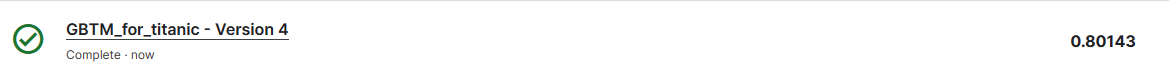